<a href="https://colab.research.google.com/github/sutummala/AutismNet/blob/main/Autism_siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import os
import tensorflow as tf
from tensorflow.keras import backend as K
#import tensorflow_addons as tfa
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
import sklearn
import nibabel as nib
import numpy as np
import random
import matplotlib.pyplot as plt

In [30]:
# normalizing the input to have values between zero and one to make them suitable for further analysis
def normalize(input):
  norm_input = []
  print(f'shape of input is {np.shape(input[0])}')
  for i in range(np.shape(input)[0]):
    norm_in = (input[i]-np.min(input[i]))/(np.max(input[i])-np.min(input[i]))
    norm_input.append(norm_in)
  return norm_input

In [31]:
left_input = np.load('/content/drive/My Drive/Autism_CNN/left_input.npy')
left_input = np.squeeze(normalize(left_input))

right_input = np.load('/content/drive/My Drive/Autism_CNN/right_input.npy')
right_input = np.squeeze(normalize(right_input))

targets = np.load('/content/drive/My Drive/Autism_CNN/autism_labels.npy')

targets = 1-targets # 1 for different pair and 0 for same pair 

print(f'total size of the data is {len(targets)}')

shape of input is (30, 45, 30)
shape of input is (30, 45, 30)
total size of the data is 4280


In [32]:
folds = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1)

for train_index, test_index in folds.split(left_input, targets):
    left_input_cv, left_input_test, targets_cv, targets_test = left_input[train_index], left_input[test_index], targets[train_index], targets[test_index]
    right_input_cv, right_input_test = right_input[train_index], right_input[test_index]

#cv_index = int(0.9 * len(targets)) 

#left_input_cv = left_input[:cv_index]
#right_input_cv = right_input[:cv_index]
#targets_cv = targets[:cv_index]

print(f'shape of left/right input for CV is {left_input_cv.shape}')
print(f'input size for cross-validation is {len(targets_cv)}')
print(f'no.of positive pairs in CV are {np.shape(np.nonzero(targets_cv))[1]}')

#left_input_test = left_input[cv_index:]
#right_input_test = right_input[cv_index:]
#targets_test = targets[cv_index:]

print(f'shape of left/right input for testing is {left_input_test.shape}')
print(f'input size for testing is {len(targets_test)}')
print(f'no.of positive pairs in test are {np.shape(np.nonzero(targets_test))[1]}')

shape of left/right input for CV is (3424, 30, 45, 30)
input size for cross-validation is 3424
no.of positive pairs in CV are 1694
shape of left/right input for testing is (856, 30, 45, 30)
input size for testing is 856
no.of positive pairs in test are 423


In [33]:
def specificity(y_true, y_pred):
    
    y_pred = K.cast(y_pred > 0.5, y_true.dtype)
    tn, fp, fn, tp = (0, 0, 0, 0)
    for i in range(len(y_true)):
      if y_true[i] == 1 and y_pred[i] == 1:
        tp += 1
      elif y_true[i] == 1 and y_pred[i] == 0:
        fn += 1
      elif y_true[i] == 0 and y_pred[i] == 1:
        fp += 1
      elif y_true[i] == 0 and y_pred[i] == 0:
        tn += 1
    return tn/(tn+fp)

In [34]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean((1-y_true) * square_pred + y_true * margin_square)

In [35]:
## newly added methods begin
def recall_m(y_true, y_pred):
  y_pred = K.cast(y_pred > 0.5, y_true.dtype)
  true_positives = (K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = (K.round(K.clip(y_true, 0, 1)))
  recall = K.mean(K.equal(true_positives, possible_positives))
  return recall

def precision_m(y_true, y_pred):
  y_pred = K.cast(y_pred > 0.5, y_true.dtype)
  true_positives = (K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = (K.round(K.clip(y_pred, 0, 1)))
  precision = K.mean(K.equal(true_positives, predicted_positives))
  return precision

def f1_m(y_true, y_pred):
  precision = precision_m(y_true, y_pred)
  recall = recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))
##newly added end

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred > 0.5, y_true.dtype)))

In [36]:
def euclidean_distance(vectors):
	# unpack the vectors into separate lists
	(featsA, featsB) = vectors
	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1,
		keepdims=True)
	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [37]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [38]:
def specificity1(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [39]:
def SiameseNetwork(input_shape):
    
    moving_input = tf.keras.Input(input_shape)
    ref_input = tf.keras.Input(input_shape)
    
    #model = tf.keras.Sequential()
    input = tf.keras.Input(input_shape)

   # 1st 3D conv blocks, which involves, convolution, BN, activation and pooling 
    x_1 = tf.keras.layers.Conv3D(32, (3,3,3), strides = (1,1,1), padding = 'same', kernel_regularizer = 'L2', name = 'conv3d_1')(input)
    x_1_bn = tf.keras.layers.BatchNormalization(axis = -1)(x_1)
    x_1_bn_ac = tf.keras.layers.Activation('relu')(x_1_bn)

    x_2 = tf.keras.layers.Conv3D(32, (3,3,3), strides = (1,1,1), padding = 'same', kernel_regularizer = 'L2', name = 'conv3d_2')(x_1_bn_ac)
    x_2 = tf.keras.layers.BatchNormalization(axis = -1)(x_2)
    x_2 = tf.keras.layers.Activation('relu')(x_2)
    x_2 = tf.keras.layers.MaxPooling3D(strides = (2, 2, 2))(x_2)
              
    # 2nd 3D conv block, which involves, convolution, BN, activation and pooling 
    x_3 = tf.keras.layers.Conv3D(64, (3,3,3), strides = (1,1,1), padding = 'same', kernel_regularizer = 'L2', name = 'conv3d_3')(x_2)
    x_3 = tf.keras.layers.BatchNormalization(axis = -1)(x_3)
    x_3 = tf.keras.layers.Activation('relu')(x_3)

    x_4 = tf.keras.layers.Conv3D(64, (3,3,3), strides = (1,1,1), padding = 'same', kernel_regularizer = 'L2', name = 'conv3d_4')(x_3)
    x_4 = tf.keras.layers.BatchNormalization(axis = -1)(x_4)
    x_4 = tf.keras.layers.Activation('relu')(x_4)
    x_4 = tf.keras.layers.MaxPooling3D(strides = (2, 2, 2))(x_4)
    
    # 3rd 3D conv block, which involves, convolution, BN, activation and pooling 
    x_5 = tf.keras.layers.Conv3D(256, (3,3,3), strides = (1,1,1), padding = 'same', kernel_regularizer = 'L2', name = 'conv3d_5')(x_4)
    x_5_bn = tf.keras.layers.BatchNormalization(axis = -1)(x_5)
    x_5_bn_ac = tf.keras.layers.Activation('relu')(x_5_bn)
    x_5_pooling = tf.keras.layers.MaxPooling3D(strides = (2, 2, 2))(x_5_bn_ac)       
    
    gap_layer = tf.keras.layers.GlobalAveragePooling3D()(x_5_pooling)
    #model.add(tf.keras.layers.Dropout(0.3))
    dense_layer = tf.keras.layers.Dense(256, activation = 'relu', kernel_regularizer = 'L2')(gap_layer)
    
    encoding_model = tf.keras.Model(inputs = input, outputs =  dense_layer, name = 'base_3dcnn')

    encoded_moving  = encoding_model(moving_input)
    encoded_ref = encoding_model(ref_input)

    L1_layer = tf.keras.layers.Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]), name = 'lambda_layer')
    #L2_layer = tf.keras.layers.Lambda(lambda tensors:K.l2_normalize((tensors[0] - tensors[1]), axis = 1))

    L1_distance = L1_layer([encoded_moving, encoded_ref]) # L1-norm
    #L2_distance = L2_layer([encoded_moving, encoded_ref]) # L2-norm or Euclidean Norm
    #L2_distance = tf.keras.layers.Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([encoded_moving, encoded_ref])

    prediction = tf.keras.layers.Dense(1, activation='sigmoid')(L1_distance)
    siamesenet = tf.keras.Model(inputs = [moving_input, ref_input], outputs = prediction, name = 'siamese_3dmodel')
    
    return siamesenet, encoding_model

In [40]:
img_shape = (30, 45, 30, 1)

In [41]:
siamese_model, base_model = SiameseNetwork(img_shape)
base_learning_rate = 0.00005
base_model.summary()
siamese_model.summary()

Model: "base_3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 30, 45, 30, 1)]   0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 30, 45, 30, 32)    896       
_________________________________________________________________
batch_normalization_10 (Batc (None, 30, 45, 30, 32)    128       
_________________________________________________________________
activation_10 (Activation)   (None, 30, 45, 30, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 30, 45, 30, 32)    27680     
_________________________________________________________________
batch_normalization_11 (Batc (None, 30, 45, 30, 32)    128       
_________________________________________________________________
activation_11 (Activation)   (None, 30, 45, 30, 32)    0

In [42]:
siamese_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate), loss = contrastive_loss, metrics = [accuracy, recall_m, specificity, precision_m, f1_m])
    
fine_tune_epochs = 20
history_fine = siamese_model.fit([left_input_cv, right_input_cv], targets_cv, batch_size = 32,
                              epochs = fine_tune_epochs,
                              shuffle = True,
                              validation_split = 0.2)

Epoch 1/20
86/86 [==============================] - 28s 307ms/step - loss: 5.0220 - accuracy: 0.5067 - recall_m: 0.7695 - specificity: nan - precision_m: 0.7373 - f1_m: 0.7370 - val_loss: 4.7771 - val_accuracy: 0.4918 - val_recall_m: 0.9915 - val_specificity: nan - val_precision_m: 0.5003 - val_f1_m: 0.6613
Epoch 2/20
86/86 [==============================] - 26s 298ms/step - loss: 4.5475 - accuracy: 0.5870 - recall_m: 0.8017 - specificity: 0.5946 - precision_m: 0.7853 - f1_m: 0.7850 - val_loss: 4.3363 - val_accuracy: 0.4904 - val_recall_m: 0.9872 - val_specificity: nan - val_precision_m: 0.5032 - val_f1_m: 0.6625
Epoch 3/20
86/86 [==============================] - 26s 298ms/step - loss: 4.1173 - accuracy: 0.6465 - recall_m: 0.8210 - specificity: 0.6598 - precision_m: 0.8256 - f1_m: 0.8144 - val_loss: 3.9494 - val_accuracy: 0.4413 - val_recall_m: 0.9020 - val_specificity: 0.3072 - val_precision_m: 0.5393 - val_f1_m: 0.6679
Epoch 4/20
86/86 [==============================] - 26s 298ms/st

<Figure size 576x576 with 0 Axes>

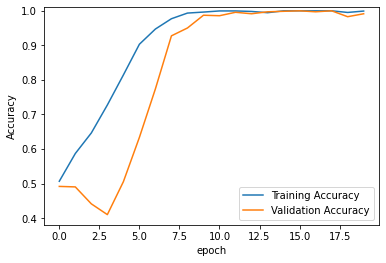

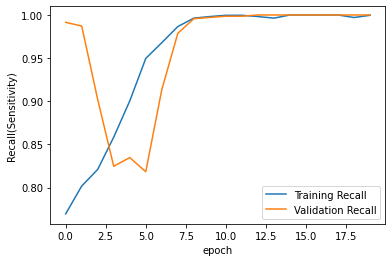

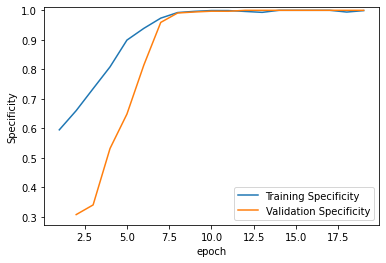

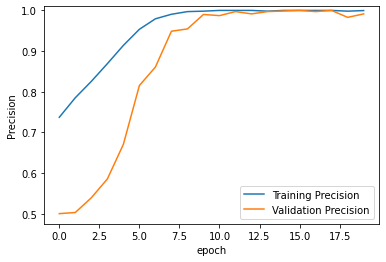

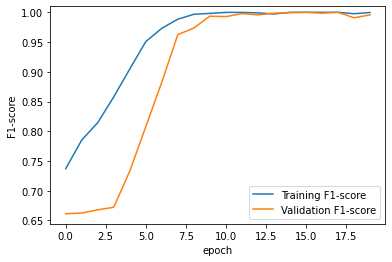

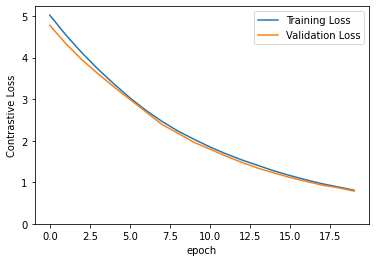

In [43]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

recall_m = history_fine.history['recall_m']
val_recall_m = history_fine.history['val_recall_m']

specificity = history_fine.history['specificity']
val_specificity = history_fine.history['val_specificity']

precision_m = history_fine.history['precision_m']
val_precision_m = history_fine.history['val_precision_m']

f1_m = history_fine.history['f1_m']
val_f1_m = history_fine.history['val_f1_m']
    
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']
    
plt.figure(figsize=(8, 8))

plt.figure()
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()),1.01])
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('epoch')

plt.figure()
plt.plot(recall_m, label='Training Recall')
plt.plot(val_recall_m, label='Validation Recall')
plt.ylim([min(plt.ylim()),1.01])
plt.legend(loc='lower right')
plt.ylabel('Recall(Sensitivity)')
plt.xlabel('epoch')

plt.figure()
plt.plot(specificity, label='Training Specificity')
plt.plot(val_specificity, label='Validation Specificity')
plt.ylim([min(plt.ylim()),1.01])
plt.legend(loc='lower right')
plt.ylabel('Specificity')
plt.xlabel('epoch')

plt.figure()
plt.plot(precision_m, label='Training Precision')
plt.plot(val_precision_m, label='Validation Precision')
plt.ylim([min(plt.ylim()),1.01])
plt.legend(loc='lower right')
plt.ylabel('Precision')
plt.xlabel('epoch')

plt.figure()
plt.plot(f1_m, label='Training F1-score')
plt.plot(val_f1_m, label='Validation F1-score')
plt.ylim([min(plt.ylim()),1.01])
plt.legend(loc='lower right')
plt.ylabel('F1-score')
plt.xlabel('epoch')

plt.figure()
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, max(plt.ylim())])
plt.legend(loc='upper right')
plt.ylabel('Contrastive Loss')
plt.xlabel('epoch')

plt.show()

In [44]:
predicton_prob = siamese_model.predict([left_input_test, right_input_test])

print(np.transpose(predicton_prob))

predicton_prob[predicton_prob > 0.5] = 1
predicton_prob[predicton_prob <= 0.5] = 0

tn, fp, fn, tp = sklearn.metrics.confusion_matrix(targets_test, predicton_prob).ravel()

print(f'test Accuracy: {sklearn.metrics.accuracy_score(targets_test, predicton_prob)}')
print(f'test ROC (AUC): {sklearn.metrics.roc_auc_score(targets_test, predicton_prob)}')
print(f'test Sensitivity (Recall): {sklearn.metrics.recall_score(targets_test, predicton_prob)}')
print(f'test Precision: {sklearn.metrics.precision_score(targets_test, predicton_prob)}')
print(f'test F1-score: {sklearn.metrics.f1_score(targets_test, predicton_prob)}')
print(f'test Mathews Correlation Coefficient: {sklearn.metrics.matthews_corrcoef(targets_test, predicton_prob)}')
print(f'test Specificity: {tn/(tn+fp)}')
print(targets_test)

[[0.08350898 0.97931117 0.9728506  0.95209575 0.9852373  0.93911964
  0.10389497 0.9899066  0.18814895 0.98267347 0.12521462 0.891786
  0.99138266 0.04477116 0.07024366 0.971893   0.18097149 0.06591893
  0.07925906 0.9792731  0.98432946 0.91400766 0.08149669 0.08424778
  0.93345624 0.9332752  0.8784443  0.05181482 0.98186994 0.9289245
  0.93501794 0.97841316 0.97910553 0.9710742  0.97651684 0.14302407
  0.08328868 0.9828166  0.981016   0.0773756  0.03564744 0.07113064
  0.0881741  0.987472   0.98658425 0.9896624  0.9708326  0.9776559
  0.11888277 0.12170921 0.9953231  0.03771869 0.9934129  0.08230848
  0.19939321 0.18963587 0.24972083 0.11026841 0.04966098 0.9687488
  0.99254227 0.9852271  0.9701799  0.15145853 0.09041845 0.9878632
  0.9522029  0.98672235 0.08462045 0.20790382 0.97354466 0.20550671
  0.96749085 0.03974584 0.96951205 0.9638604  0.12068623 0.98692745
  0.9952873  0.25994757 0.11965321 0.9378899  0.96387845 0.03474321
  0.08848056 0.93020076 0.03474321 0.06924599 0.205445

In [45]:
# Save Model
siamese_model.save('/content/drive/My Drive/Autism_CNN/autism_cnn_model')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Autism_CNN/autism_cnn_model/assets


In [46]:
siamese_model = tf.keras.models.load_model('/content/drive/My Drive/Autism_CNN/autism_cnn_model', custom_objects={'contrastive_loss':contrastive_loss, 'accuracy':accuracy, 'recall_m':recall_m, 'specificity': specificity, 'precision_m':precision_m, 'f1_m':f1_m})
print('Model is loaded')

Model is loaded


In [47]:

left_test = np.expand_dims(left_input_test[0], axis = (0, -1))
print(left_test.shape)
right_test = np.expand_dims(right_input_test[0], axis = (0, -1))
p = siamese_model.predict([left_test, right_test])
print(f'predicted probability is {p[0][0]} and actual probability is {targets_test[0]}')

(1, 30, 45, 30, 1)
predicted probability is 0.08350886404514313 and actual probability is 0.0


In [49]:
#tf.keras.utils.plot_model(siamese_model, show_shapes=True, show_dtype=True)

In [50]:
_, siamese_embeddings_model = SiameseNetwork(img_shape)
siamese_embeddings_model.summary()

Model: "base_3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 30, 45, 30, 1)]   0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 30, 45, 30, 32)    896       
_________________________________________________________________
batch_normalization_15 (Batc (None, 30, 45, 30, 32)    128       
_________________________________________________________________
activation_15 (Activation)   (None, 30, 45, 30, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 30, 45, 30, 32)    27680     
_________________________________________________________________
batch_normalization_16 (Batc (None, 30, 45, 30, 32)    128       
_________________________________________________________________
activation_16 (Activation)   (None, 30, 45, 30, 32)    0

In [51]:

embeddings_weights = siamese_model.layers[-3].get_weights()
siamese_embeddings_model.set_weights(embeddings_weights)

In [490]:
test_L = np.expand_dims(left_input_test[-6], axis = (0, -1))
test_R = np.expand_dims(right_input_test[-6], axis = (0, -1))

In [491]:
last_conv_layer = siamese_embeddings_model.get_layer('conv3d_5')
new_embeddings_model = tf.keras.models.Model(siamese_embeddings_model.inputs, [last_conv_layer.output, siamese_embeddings_model.output])

last_conv_output_left, vector_left = new_embeddings_model.predict(test_L)
last_conv_output_right, vector_right = new_embeddings_model.predict(test_R)

In [492]:
last_conv_output_left = np.squeeze(last_conv_output_left)
last_conv_output_left.shape

(7, 11, 7, 256)

In [493]:
last_conv_output_right = np.squeeze(last_conv_output_right)
last_conv_output_right.shape

(7, 11, 7, 256)

In [494]:
#abs(vector_left - vector_right)

In [495]:
lambda_layer = siamese_model.get_layer('lambda_layer')
s_model = tf.keras.models.Model(inputs = [siamese_model.inputs], outputs = [lambda_layer.output, siamese_model.output])
L1, prediction = s_model.predict([test_L, test_R])

In [496]:
L1 = np.squeeze(L1)
L1.shape, np.min(L1), np.max(L1), np.mean(L1)

((256,), 0.0, 1.5303856, 0.25183347)

In [497]:
heat_map = np.zeros(last_conv_output_left.shape[0:3], dtype = np.float32)

In [498]:
for index, w in enumerate(L1):
  heat_map += w * last_conv_output_left[:, :, :, index]

In [499]:
heat_map[heat_map < 0] = 0

In [500]:
np.min(heat_map), np.max(heat_map), np.mean(heat_map)

(0.0, 7.228695, 2.8158534)

Text(0.5, 1.0, 'HeatMap-Sagittal')

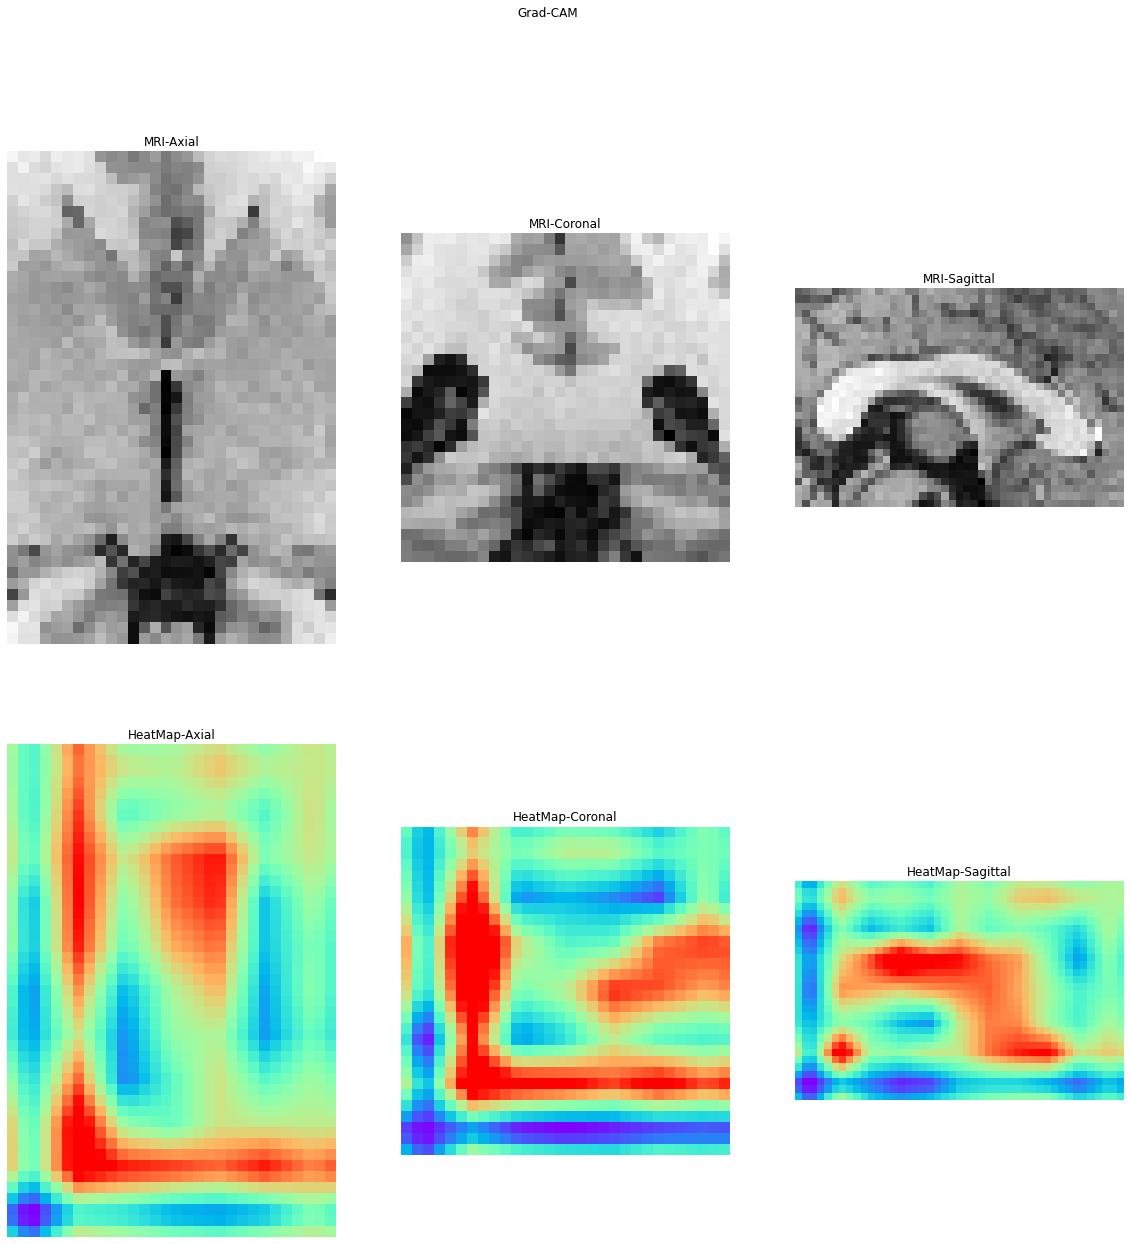

In [503]:
from skimage.transform import resize
import cv2

hm = resize(heat_map, (30, 45, 30))

#heatmap = (hm - hm.min())/(hm.max() - hm.min())
heatmap = hm

f, axarr = plt.subplots(2,3, figsize=(20,20));
f.suptitle('Grad-CAM')
slice_count=14
slice_count2=5

mri_image = np.squeeze(test_L)

sagittal_mri_img=np.rot90(np.squeeze(mri_image[slice_count, :, :]))
sagittal_grad_cmap_img=np.rot90(np.squeeze(heatmap[slice_count, :, :]))
#sagittal_overlay=cv2.addWeighted(sagittal_mri_img, 0.3, sagittal_grad_cmap_img, 0.6, 0)

coronal_mri_img=np.rot90(np.squeeze(mri_image[:, slice_count2, :]))
coronal_grad_cmap_img=np.rot90(np.squeeze(heatmap[:, slice_count2, :]))
#coronal_overlay=cv2.addWeighted(coronal_mri_img, 0.3, coronal_grad_cmap_img, 0.6, 0)

axial_mri_img=np.rot90(np.squeeze(mri_image[:, :, slice_count2]))
axial_grad_cmap_img=np.rot90(np.squeeze(heatmap[:, :, slice_count2]))
#axial_overlay=cv2.addWeighted(axial_mri_img, 0.3, axial_grad_cmap_img, 0.6, 0)

img_plot = axarr[0,0].imshow(axial_mri_img, cmap='gray');
axarr[0,0].axis('off')
axarr[0,0].set_title('MRI-Axial')
    
img_plot = axarr[0,1].imshow(coronal_mri_img, cmap='gray');
axarr[0,1].axis('off')
axarr[0,1].set_title('MRI-Coronal')

img_plot = axarr[0,2].imshow(sagittal_mri_img, cmap='gray');
axarr[0,2].axis('off')
axarr[0,2].set_title('MRI-Sagittal')

img_plot = axarr[1,0].imshow(axial_grad_cmap_img, cmap=plt.cm.rainbow, vmax = 5, alpha = 1);
axarr[1,0].axis('off')
axarr[1,0].set_title('HeatMap-Axial')
    
img_plot = axarr[1,1].imshow(coronal_grad_cmap_img, cmap=plt.cm.rainbow, vmax = 5, alpha = 1);
axarr[1,1].axis('off')
axarr[1,1].set_title('HeatMap-Coronal')

img_plot = axarr[1,2].imshow(sagittal_grad_cmap_img, cmap=plt.cm.rainbow, vmax = 5, alpha = 1);
axarr[1,2].axis('off')
axarr[1,2].set_title('HeatMap-Sagittal')

#img_plot = axarr[2,0].imshow(axial_overlay, cmap=plt.cm.rainbow, alpha = 1);
#axarr[2,0].axis('off')
#axarr[2,0].set_title('Overlay-Axial')
    
#img_plot = axarr[2,1].imshow(coronal_overlay, cmap=plt.cm.rainbow, alpha = 1);
#axarr[2,1].axis('off')
#axarr[2,1].set_title('Overlay-Coronal')

#img_plot = axarr[2,2].imshow(sagittal_overlay, cmap=plt.cm.rainbow, alpha = 1);
#axarr[2,2].axis('off')
#axarr[2,2].set_title('Overlay-Sagittal')
        